## Imports

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import dataframe_image as dfi

In [2]:
dir_files = '../Dataset/'
col_labels = [
    'Dev Id',
    'Acc X',
    'Acc Y',
    'Acc Z',
    'Gyr X',
    'Gyr Y',
    'Gyr Z',
    'Mag X',
    'Mag Y',
    'Mag Z',
    'Timestamp',
    'Label'
]

act_labels = np.array([
    'Stand',
    'Sit',
    'Sit and Talk',
    'Walk',
    'Walk and Talk',
    'Climb Stairs (CS)',
    'CS and Talk',
    'Stand to Sit',
    'Sit to Stand',
    'Stand to Sit and Talk',
    'Sit to Stand and Talk',
    'Stand to Walk',
    'Walk to Stand',
    'Stand to CS/CS and Talk',
    'CS to Walk',
    'CS and Talk to Walk and Talk'
])

modules_labels = [
    'N Total',
    'N Outliers',
    'Density'
]

k_values = [
    3,
    3.5,
    4
]

acts = np.array([
    1,
    8,
    14
])

## Read Files

In [3]:
def read_file(id=0, dev=2):
    file_path = dir_files + 'part' + str(id) + '/part' + str(id) + 'dev' + str(dev) + '.csv'

    csv_file = open(file_path)
    csv_reader = csv.reader(csv_file, delimiter=',')
    data_np = np.array(list(csv_reader)).astype(float)

    data = pd.DataFrame(data_np)
    data.columns = col_labels
    
    return [data,data_np]
    

[data,data_np] = read_file()
data

,Dev Id,Acc X,Acc Y,Acc Z,Gyr X,Gyr Y,Gyr Z,Mag X,Mag Y,Mag Z,Timestamp,Label
0,2.0,3.0317,9.0450,3.1739,0.762470,3.70710,-0.313840,0.57764,0.68849,1.26540,63.629,1.0
1,2.0,2.9591,9.0436,3.1400,0.405880,4.66820,-0.101480,0.58385,0.68849,1.27410,83.160,1.0
2,2.0,2.9465,9.0545,3.0799,0.242300,5.52250,0.348570,0.56522,0.67857,1.26750,102.690,1.0
3,2.0,2.7898,9.0528,3.0726,0.498580,6.34630,0.611270,0.56108,0.65476,1.26100,122.220,1.0
4,2.0,2.6924,9.0377,2.9794,0.631970,6.69720,1.005600,0.57764,0.69246,1.26750,141.750,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
52859,2.0,2.3837,9.0681,3.4339,-0.429610,-1.75440,-0.300480,0.35197,0.88294,0.69737,1039200.000,1.0
52860,2.0,2.4075,8.9945,3.3985,-0.279800,-1.72390,0.129850,0.35197,0.86706,0.69079,1039200.000,1.0
52861,2.0,2.3837,9.0316,3.4346,-0.043147,-0.77803,0.195980,0.32919,0.84722,0.69956,1039300.000,1.0
52862,2.0,2.3236,9.0922,3.4472,-0.125830,-0.56445,-0.016121,0.33747,0.88889,0.70614,1039300.000,1.0


## Modules

In [4]:
def calc_mod(data):
    acc = np.sqrt((data['Acc X']**2 + data['Acc Y']**2 + data['Acc Z']**2))
    gyr = np.sqrt((data['Gyr X']**2 + data['Gyr Y']**2 + data['Gyr Z']**2))
    mag = np.sqrt((data['Mag X']**2 + data['Mag Y']**2 + data['Mag Z']**2))
    
    frame = {
        'Dev Id': data['Dev Id'],
        'Acc': acc,
        'Gyr': gyr,
        'Mag': mag,
        'Timestamp': data['Timestamp'],
        'Label': data['Label']
    }
    
    return pd.DataFrame(frame)

data_mod = calc_mod(data)
data_mod

,Dev Id,Acc,Gyr,Mag,Timestamp,Label
0,2.0,10.053699,3.797690,1.552071,63.629,1.0
1,2.0,10.020108,4.686910,1.561483,83.160,1.0
2,2.0,10.007578,5.538792,1.544826,102.690,1.0
3,2.0,9.958767,6.395135,1.527626,122.220,1.0
4,2.0,9.889685,6.801699,1.555547,141.750,1.0
...,...,...,...,...,...,...
52859,2.0,9.985196,1.831058,1.178894,1039200.000,1.0
52860,2.0,9.911957,1.751280,1.163128,1039200.000,1.0
52861,2.0,9.952301,0.803493,1.146966,1039300.000,1.0
52862,2.0,9.997520,0.578530,1.184333,1039300.000,1.0


## Density

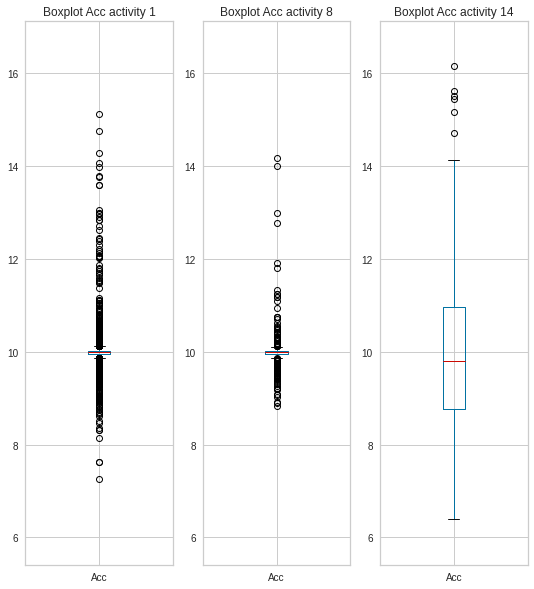

,Label,N Total,N Outliers,Density
1,Stand,11012,762,6.919724
8,Stand to Sit,384,116,30.208333
14,Stand to CS/CS and Talk,254,6,2.362205


In [5]:
def get_density_outliers(data_act):
    k=1.5
    column = data_act.columns[0]

    quart = data_act[column].quantile([0.25,0.75])
    iqr = quart[0.75] - quart[0.25]
    lim = [quart[0.25] - k*iqr, quart[0.75] + k*iqr]

    outliers = data_act.loc[(data_act[column] < lim[0]) | (data_act[column] > lim[1])]
    not_outliers = data_act.loc[(data_act[column] >= lim[0]) & (data_act[column] <= lim[1])]

    return [outliers,not_outliers]

def getDensity(data_act):

    outliers = get_density_outliers(data_act)[0]

    n = data_act.shape[0]

    return [outliers.shape[0] / n * 100, n, outliers.shape[0]]  #densidade, nº de pontos, nº de outliers

def plotBoxplot(data,vec_name):
    column = data.columns[0]

    plt.figure(figsize=(3*len(acts),10))
    act_title=''

    min_v = data.loc[data['Label'].isin(acts),vec_name].min().min()
    max_v = data.loc[data['Label'].isin(acts),vec_name].max().max()
    amp = max_v - min_v

    for i in range(1,len(acts)+1):
        act = acts[i-1]
        plt.subplot(1,len(acts),i)

        data_act = data.loc[data['Label'] == act]

        box = data_act[vec_name].plot.box()
        plt.title('Boxplot ' + vec_name + ' activity ' + str(act))
        if(i!=1):
            act_title += ','
        act_title += str(act)

        box.set_ylim(min_v - 0.1*amp, max_v + 0.1*amp)

    plt.savefig('../Plots/Boxplots/'+'boxplot-' + vec_name + '-acts-' + act_title)
    
    plt.show()

def evaluateDensity(data,title):
    density = [act_labels[acts-1],[],[],[]]
    
    for act in acts:
        data_act = data.loc[data['Label'] == act]
        [dens,n,n_out] = getDensity(data_act)
        density[1].append(n)
        density[2].append(n_out)
        density[3].append(dens)
    
    density[0] = pd.DataFrame(density[0])
    density[0].columns = ['Label']

    for i in range(1,len(density)):
        density[i] = pd.DataFrame(density[i])
        density[i].columns = [modules_labels[i-1]]
    
    density = pd.concat(density,axis=1)
    density.index = acts
    plotBoxplot(data,title)
    
    return density
    
density_acc = evaluateDensity(data_mod[['Acc','Label']], 'Acc')
display(density_acc)

density = density_acc

### 3.2.
<p> As atividades 8 a 11 consistem alternar entre estar em pé e sentado, ou vice-versa, enquanto o indivíduo realiza outras atividades (falar). A densidade de outliers nestes casos é muito alto. Isto pode dever-se a 2 coisas: 

<ul>
<li> O indivíduo pode ter-se movimentado mais rápido nuns momentos do que noutros, gerando uma grande variedade nos valores. 
<li> Como há menos momentos destas atividades (como podemos observar na tabela na columa 'Acc_n'), e dada a situação anterior, os momentos que se tornam outliers tornam-se demasiados em comparação com o número de momentos da atividade em causa.
<ul>

<p> As atividades semelhantes, como <em>Climb Stairs to Walk</em> e <em>Climb Stairs and Talk to Walk and Talk</em> têm densidades semelhantes. Conclui-se, assim, que adicionar a atividade <em>Talk</em> não modifica de forma significativa o número de outliers. Tal acontece também nas outras atividades que apenas é adicionado o <em>Talk</em>, a diferença da densidade de outliers é pequena.

<p> Na atividade <em>Sit</em> (atividade 2) e <em>Sit and Talk</em>, o intervalo de valores é pequeno pois, quando uma pessoa está sentada, não se movimenta pelo que a aceleração no eixo <em>xx'</em> e <em>yy'</em> é perto de 0.

<p> Nas atividades <em>Climb</em> e <em>Climb and Talk</em>, o intervalo de valores é alto pois o indivíduo tem, geralmente, uma aceleração inconstante quando sobe ou desce escadas, gerando os outliers. A densidade é baixa mas quando é gerado um outlier, este tem um valor muito longe da média.

## Z-Score

,Label,N Total,Boxplot,Z-score k=3,Z-score k=3.5,Z-score k=4
1,Stand,11012,762,128,109,98
8,Stand to Sit,384,116,6,6,4
14,Stand to CS/CS and Talk,254,6,2,0,0


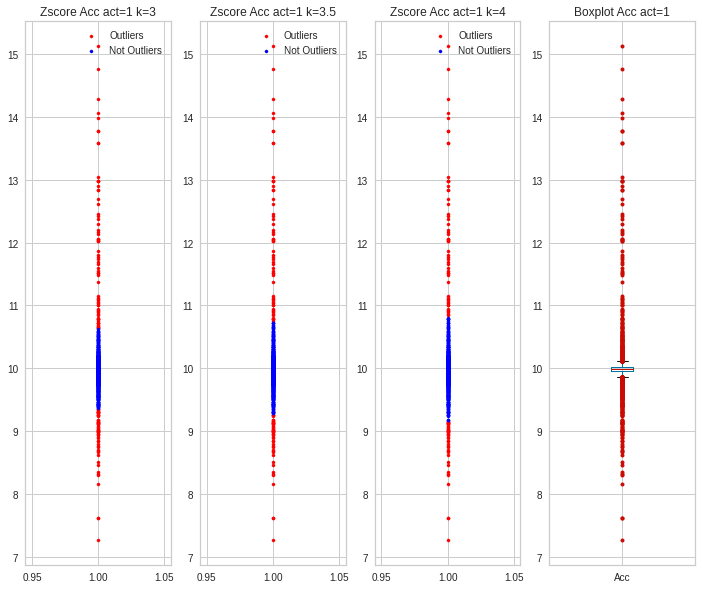

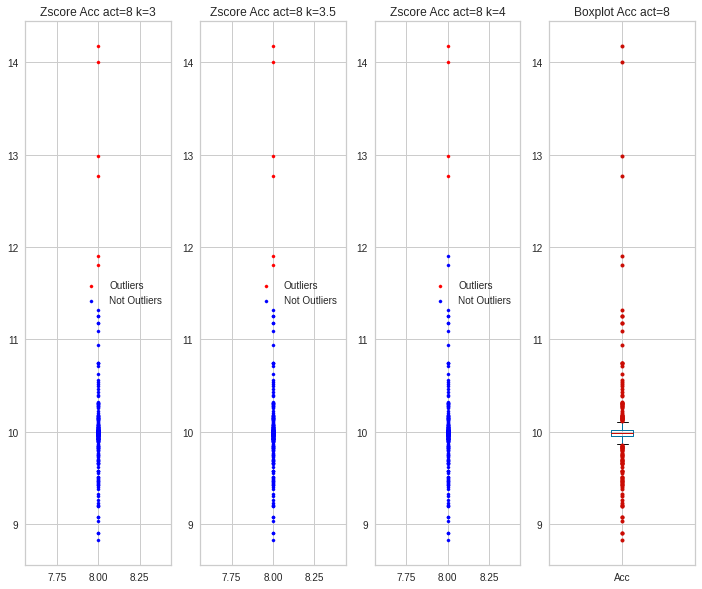

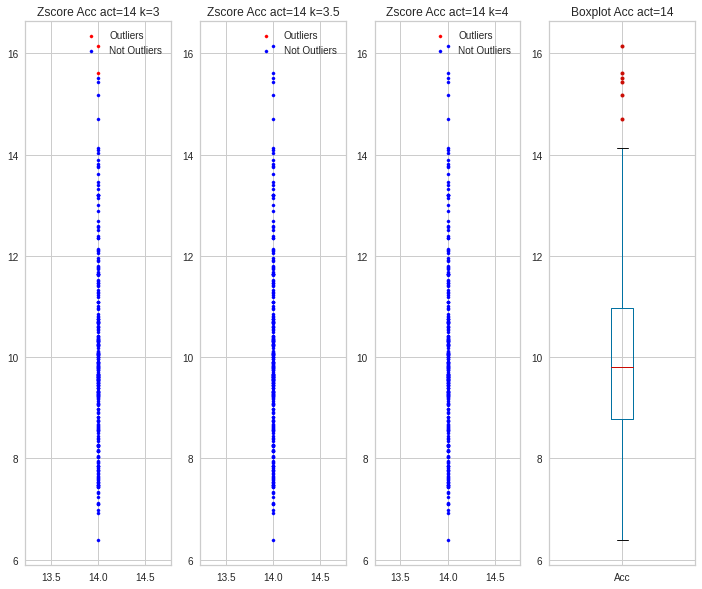

In [6]:
def plotZscore(data,vec_name):
    column = data.columns[0]
    for act in acts:
        data_act = data.loc[data['Label'] == act,column]

        plt.figure(figsize=(3*(len(k_values)+1),10))
        for i in range(1,len(k_values)+1):
            k = k_values[i-1]

            [outliers,not_outliers] = zscore(data_act,k)

            plt.subplot(1,len(k_values)+1,i)
            plt.scatter(np.full((1,outliers.shape[0]),act),outliers,s=10,c='red',label='Outliers')
            plt.scatter(np.full((1,not_outliers.shape[0]),act),not_outliers,s=10,c='blue',label='Not Outliers')
            plt.title('Zscore ' + vec_name + ' act=' + str(act) + ' k=' + str(k))
            plt.legend()

        plt.subplot(1,len(k_values)+1,len(k_values)+1)
        data_act.plot.box(sym='r.')
        plt.title('Boxplot ' + vec_name + ' act=' + str(act))
        plt.savefig('../Plots/Zscores/'+'zscore-act-' + str(act))

def zscore(data,k):
    z = (data - data.mean()) / data.std()
    
    out_pos = z.loc[(z < -k) | (z > k)].index
    not_out_pos = z.loc[(z >= -k) & (z <= k)].index

    out = data.loc[out_pos]
    not_out = data.loc[not_out_pos]

    return [out,not_out]

def outliersZscore(density,data,vec_name,n_act=16):
    column = data.columns[0]
    n_outliers = list() 
        
    for act in acts:
        k_out = list()
        for k in k_values:
            data_act = data.loc[data['Label'] == act,column]
            [out,not_out] = zscore(data_act,k)

            k_out.append(out.shape[0])

        df = pd.DataFrame(k_out)
        df.columns = [act]
        df.index = k_values
        n_outliers.append(df)

    n_outliers = pd.concat(n_outliers,axis=1)
    n_outliers = n_outliers.transpose()

    data_zscore = pd.concat([density[['Label','N Total','N Outliers']],n_outliers],axis=1)
    data_zscore = data_zscore.rename(columns = {'N Outliers': 'Boxplot'})

    for k in k_values:
        data_zscore = data_zscore.rename(columns={k: 'Z-score k=' + str(k)})

    plotZscore(data,vec_name)
    
    dfi.export(data_zscore,'../Plots/Tables/table-zscore-' + vec_name.lower() + '.png')
    
    return data_zscore

acc_zscore = outliersZscore(density_acc,data_mod[['Acc','Label']],'Acc')

display(acc_zscore)

### 3.5.

<p> A análise de outliers através do Boxplot é feito através da densidade. Logo, quando os dados estão concentrados, este método vais ser muito sensível a outliers pois o limite para os definir vai ser curto. No caso do Z-score, os outliers são os valores que estão mais afastados da média <em>x</em> desvios padrões. Olhando para uma distribuição normal, estão mais no exterior da mesma, sendo um algoritmo menos sensível a outliers.

<p> Conseguimos perceber que o estudo da densidade considera certos pontos como outliers quando estes estão num zona concentrada. No caso do Z-score, já conseguimos detetar os outliers quando estes estão mais dispersos e escassos.

In [7]:
def assign_clusters(data, centroids):
    for index, row in data.iterrows():
        for i in range(len(centroids)):
            d_actual = np.sqrt((row['X'] - centroids[int(row['Clusters'])][0])**2 + (row['Y'] - centroids[int(row['Clusters'])][1])**2 + (row['Z'] - centroids[int(row['Clusters'])][2])**2)
            d_compare = np.sqrt((row['X'] - centroids[i][0])**2 + (row['Y'] - centroids[i][1])**2 + (row['Z'] - centroids[i][2])**2)
            if (d_actual > d_compare):
                data.loc[index, 'Clusters'] = i
                data.loc[index, 'Distance'] = d_compare
    return data

def update_centroids(data, centroids):
    for i in range(len(centroids)):
        centroids[i][0] = data['X'].loc[data['Clusters'] == i].mean()
        centroids[i][1] = data['Y'].loc[data['Clusters'] == i].mean()
        centroids[i][2] = data['Z'].loc[data['Clusters'] == i].mean()
    
    return centroids
        
def k_means(n_clusters, data):
    centroids = [[] for _ in range(n_clusters)]
    
    for i in range(n_clusters):
        centroids[i] = data.sample().to_numpy()[0]
        
    data['Clusters'] = 0
    data['Distance'] = 0
    prev_clusters = data['Clusters'].copy()
    
    while(True):
        data = assign_clusters(data, centroids)
        
        if (data['Clusters'].equals(prev_clusters)):
            break
        
        centroids = update_centroids(data, centroids)
        prev_clusters = data['Clusters'].copy()
        
    return [data, centroids]
    

def clusters_kmeans(n_clusters, data, act):
    data = data.loc[data['Act_Label'] == act]
    
    acc_xyz = data[['Acc_X', 'Acc_Y', 'Acc_Z']]
    acc_xyz = acc_xyz.rename(columns={"Acc_X":"X", "Acc_Y":"Y", "Acc_Z":"Z"})
    gyr_xyz = data[['Gyr_X', 'Gyr_Y', 'Gyr_Z']]
    gyr_xyz = gyr_xyz.rename(columns={'Gyr_X':'X', 'Gyr_Y':'Y', 'Gyr_Z':'Z'})
    mag_xyz = data[['Mag_X', 'Mag_Y', 'Mag_Z']]
    mag_xyz = mag_xyz.rename(columns={'Mag_X':'X', 'Mag_Y':'Y', 'Mag_Z':'Z'})
    
    [acc_xyz, centroids] = k_means(n_clusters, acc_xyz)
#     [gyr_xyz, centroids] = k_means(n_clusters, gyr_xyz)
#     [mag_xyz, centroids] = k_means(n_clusters, mag_xyz)
    
    # %matplotlib notebook
    # threedee = plt.figure().gca(projection='3d')
    # for i in range(n_clusters):
    #    cluster_label = 'Cluster '+str(i)
    #    plot_data = acc_xyz.loc[acc_xyz['Clusters'] == i]
    #    threedee.scatter(plot_data['X'], plot_data['Y'], plot_data['Z'], marker='o', label=cluster_label)
    # title = 'Accelerometer kmeans'
    # plt.title(title)
    # threedee.legend()
    
#     fig2 = plt.figure()
#     ax = plt.axes(projection='3d')
#     for i in range(n_clusters):
#         plot_data = gyr_xyz.loc[gyr_xyz['Clusters'] == i]
#         ax.scatter3D(plot_data['X'], plot_data['Y'], plot_data['Z'])
    
#     fig3 = plt.figure()
#     ax = plt.axes(projection='3d')
#     for i in range(n_clusters):
#         plot_data = mag_xyz.loc[mag_xyz['Clusters'] == i]
#         ax.scatter3D(plot_data['X'], plot_data['Y'], plot_data['Z'])
    kmeanModel = KMeans(n_clusters=n_clusters)
    kmeanModel.fit(acc_xyz)

    return [acc_xyz,kmeanModel.inertia_]
    
# acc_clusters = clusters_kmeans(6, data, 1)

In [8]:
def createDf(clusters=[2],n_act=16):
    dfs = list()
    elbow = list()
    for clust in clusters:
        vec = list()
        vec_elbow = list()
        for act in range(1,n_act+1):
            vec.append(None)
            vec_elbow.append(None)
        elbow.append(vec_elbow)
        df = pd.DataFrame(vec)
        df.columns = [clust]
        dfs.append(df)
    
    dfs = pd.concat(dfs,axis=1)
    dfs.index = dfs.index+1

    return [dfs,elbow]

# clusters_values = [2,3,4,5,6,7,8]
# [kmeans_vec,elbow] = createDf(clusters_values)

In [9]:
def outliersKmeans(data,kmeans_vec,elbow,n_clust=7,n_act=16):
    for act in kmeans_vec.index:
        print('act',act)
        for clust in [6]:
            print('clust',clust)
            if(kmeans_vec[clust][act] == None):
                [clusters,dist] = clusters_kmeans(clust, data, act)
                elbow[clust-clusters_values[0]][act-1] = dist
                count = clusters['Clusters'].value_counts()
                minCluster = clusters.loc[clusters['Clusters'] == count.index[-1]]
                kmeans_vec[clust][act] = minCluster.shape[0]

    elbow = pd.DataFrame(elbow)

    return [kmeans_vec,elbow]

# display(acc_clusters)
# display(acc_clusters)
# print(kmeans_vec.index)
# [kmeans_vec,elbow] = outliersKmeans(data,kmeans_vec,elbow)
# display(kmeans_vec)
# display(elbow)


In [10]:
# elbow = np.array(elbow)
# plt.plot(clusters_values,elbow[:,0])

# display(kmeans_vec)
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(4,12))

# act = 8
# x = data.loc[data['Act_Label'] == act,['Acc_X','Acc_Y']].to_numpy()
# print(x)
# visualizer.fit(x)        # Fit the data to the visualizer
# visualizer.show()


### 3.7.

<p> O k-means é um algoritmo que, quando utilizado para detetar outliers, separa-os devido às suas coordenadas. Ou seja, um ponto tem de estar afastado dos restantes pontos. Ao contrário deste algoritmo, o z-score avalia os outliers pela sua distância ao centro. Pode acontecer um ponto ter uma coordenada muito mais alta que as outras e é considerado outlier pelo z-score mas não pelo k-means pois pode estar próximo de outros pontos e formar um cluster.</p>

## Exercício 3.8

In [45]:
def outlier_injection(data, x, k=3):
    max_iterations = 10
    iterations = 0
    
    data = data.copy()
    
    out, non_out = zscore(data, k)
    out_dens = out.count()/data.count() * 100
    
    print('Initial density: {:.3f}'.format(out_dens))
    
    while (out_dens < 0.99*x and iterations < max_iterations):
        mean = data.mean()
        std = data.std()
        z = 3
        
        d = x - out_dens
        n_points = int(np.ceil(d*data.count() / 100))
        inj_points = non_out.sample(n_points)
        
        for index, value in inj_points.items():
            s = np.random.randint(2)
            if s == 0:
                s = -1
            q = np.random.uniform(0, z)
            data[index] = mean + s*k*(std + q)
        
        out, non_out = zscore(data, k)
        out_dens = out.count()/data.count() * 100
        iterations += 1
    
    print('Final density: {:.3f}'.format(out_dens))
    return [data, out, non_out]
        
        
    

def outlier_injection_zscore(data, x, density, k=3):
    column = data.columns[0]
    for act in acts:
        print(act)
        data_act = data.loc[data['Label'] == act,column]
        n_samples = data_act.shape[0]

        [outliers,not_outliers] = zscore(data_act, k) 
        n_out = outliers.shape[0]
        out_dens = n_out / n_samples * 100
        print('out_dens initial:',out_dens)
        while(out_dens < 0.99*x):
            mean = data_act.mean()
            std = data_act.std()

            if(n_out > 0):
                max_out = outliers.abs().max()
                print('max_out',max_out)
                z = max_out - (mean + k*std)

            else:
                z = 3

            d = x - out_dens
            num_inj = int(np.ceil(d * n_samples / 100))
            print('inj points',num_inj)

            inj_points = not_outliers.sample(num_inj)
            
            for index in inj_points.index:
                s = np.random.randint(2)
                if s == 0:
                    s = -1
                q = np.random.uniform(0, z)
                data_act[index] = mean + s*k*(std + q)

            [outliers,not_outliers] = zscore(data_act, k) 
            n_out = outliers.shape[0]
            out_dens = n_out / n_samples * 100

            print('out_dens:',out_dens)

        data[data_act.index,column] = data_act
    return data


# display(outliersZscore(acc, 'ACC'))
#acc_injection = outlier_injection_zscore(data[['Acc','Label']], 10, density_acc)
# display(outliersZscore(acc_injection, 'ACC INJ'))
# [cena, out] = outlier_injection(data_mod['Acc'], 5)
# 1 out inicial  6.919723937522702
# out novo  9.244460588448964
# out novo  9.916454776607338
# 8 out inicial  30.208333333333332
# 14 out inicial  2.3622047244094486
# out novo  9.448818897637794

# Exercício 3.9

In [41]:
def linear_model(window, p):
    y = np.matrix([[window[i]] for i in range(p, len(window)) ])
    x = []
    for i in range(p, len(window)):
        aux = [window[i - j] for j in range(1, p+1)]
        aux.insert(0, 1)
        x.append(aux)
    x = np.matrix(x)
    
    betas = np.squeeze(np.asarray(np.dot(np.linalg.pinv(x), y)))
    predictions = np.squeeze(np.asarray(np.dot(x, betas)))
    predictions = np.append(window[:p], predictions)
    
    error_array = np.asarray(abs(window - predictions))
    error = np.sum(np.power(error_array, 2))
    
    return [betas, predictions, error_array, error]

# Exercício 3.10

Initial density: 2.115
Final density: 4.462


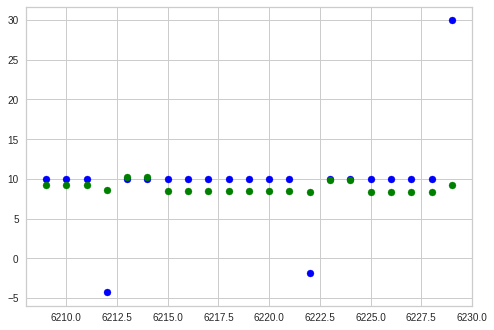

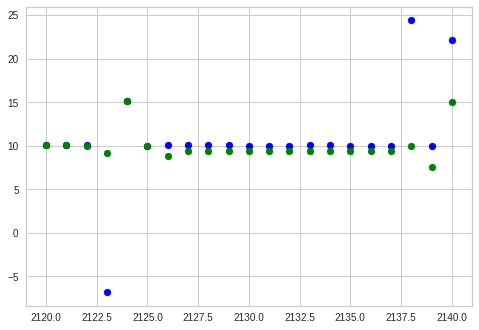

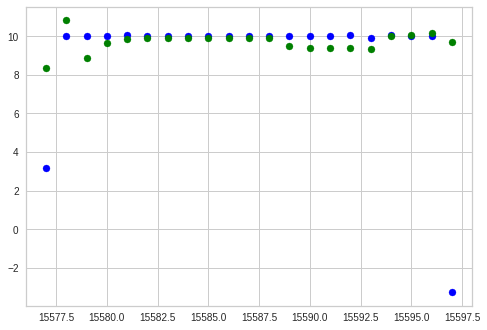

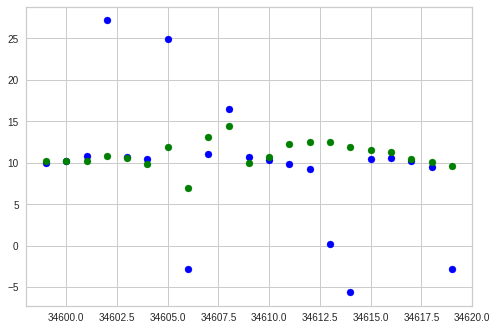

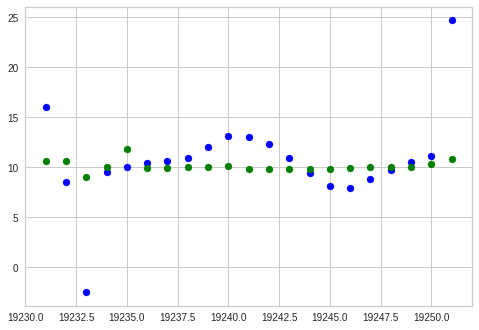

In [85]:
def ex310(data, window_size, p):
    [inj_data, outliers, non_outliers] = outlier_injection(data, 5)
    pred_data = inj_data.copy()
    
    for index, value in inj_data.items():
        if index <= p:
            continue
            
        if index < window_size:
            window = inj_data[:index+1].array
        else:
            window = inj_data[index-window_size:index+1].array
            
        [betas, predictions, error_array, trash] = linear_model(window, p)
        pred_data[index] = predictions[-1]
    
    error = abs(inj_data-pred_data)
    
    out_plot = outliers.sample(5)
    for index, value in out_plot.items():
        real_values = inj_data[index-20:index+1]
        predicted_values = pred_data[index-20:index+1]
        
        plt.figure()
        plt.scatter(real_values.index.values, real_values, color='blue')
        plt.scatter(predicted_values.index.values, predicted_values, color='green')
        
        
    
ex310(data_mod['Acc'], 30, 2)